### Dice Loss Calculation
    In this notebook, we will understand how Dice Loss is calculated. Also since we are using DiceLoss from Segmentation 
    Models package, we will look at some internals of how it's implemented. The formula for Dice Loss is as follows:
    
        L(tp,fp,fn)=1 - ((1+β2)⋅tp/(1+β2)⋅tp+β2⋅fn+fp)
    
    where
        β2 = β Square
        tp - true positives
        fp - false positives
        fn - false negatives

In [1]:
import numpy as np

In [2]:
CHANNEL_ZERO = 0
CHANNEL_ONE = 1

In [3]:
# Imagine we have a mask (technically this is either a numpy array or tensor) of size (H, W, C) = (2, 2, 2)
gt = np.array([
                    [
                        [1.0, 0.], 
                        [1.0, 0.]
                    ],
                    [
                        [0., 0.], 
                        [1.0, 1.0]
                    ]
                ], dtype='float32')
gt.shape

(2, 2, 2)

In [4]:
# Let's see what values we have for first channel
gt[:,:,CHANNEL_ZERO]

array([[1., 1.],
       [0., 1.]], dtype=float32)

In [5]:
# Let's see what values we have for second channel
gt[:,:,CHANNEL_ONE]

array([[0., 0.],
       [0., 1.]], dtype=float32)

In [6]:
# Well, when model is going to predict it may give different values. We don't have model so let's simulate this behaviour.
# i.e. Let's create a predicted mask which is slightly different than ground truth mask.
pred = np.copy(gt)

# In first channel, let's just invert the values of 1s with 0s & 0s with 1s.
pred[:,:,CHANNEL_ZERO] = np.where((pred[:,:,CHANNEL_ZERO] == 1), 0, 1)

In [7]:
# Now let's check the values we got in first channel in predicted mask
pred[:,:,CHANNEL_ZERO]

array([[0., 0.],
       [1., 0.]], dtype=float32)

In [8]:
# Take time to compare first channel of predicted mask with ground truth mask. You will see that in predicted mask we 
# have replaced 1s with 0s & 0s with 1s

In [9]:
# Now we got gt (ground truth mask) & pred (predicted mask), we can calculated Dice Loss. 
# First we will use sm.losses.DiceLoss class from segmentation_models package to compute Dice Loss. After that we will 
# inspect the lower level code of sm.losses.DiceLoss to see how it calculates Dice Loss.

In [10]:
import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [11]:
# We first need an instance of DiceLoss
dice_loss = sm.losses.DiceLoss()

# We could have passed following arguments to DiceLoss constructor. For now, we will got with default values.
# Args:
#         beta: Float or integer coefficient for precision and recall balance.
#         class_weights: Array (``np.array``) of class weights (``len(weights) = num_classes``).
#         class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
#         per_image: If ``True`` loss is calculated for each image in batch and then averaged,
#         else loss is calculated for the whole batch.
#         smooth: Value to avoid division by zero.

In [12]:
# Now we pass gt & pred to compute Dice Loss
loss = dice_loss(gt, pred)
print(loss)

tf.Tensor(0.66666555, shape=(), dtype=float32)


In [13]:
# So for given gt & pred, we got Dice Loss = 0.66666555. Now let's have a look at internal mechanics of sm.losses.DiceLoss.

class DiceLoss(Loss):

    r"""Creates a criterion to measure Dice loss:
    .. math:: L(precision, recall) = 1 - (1 + \beta^2) \frac{precision \cdot recall}
        {\beta^2 \cdot precision + recall}
    The formula in terms of *Type I* and *Type II* errors:
    .. math:: L(tp, fp, fn) = \frac{(1 + \beta^2) \cdot tp} {(1 + \beta^2) \cdot fp + \beta^2 \cdot fn + fp}
    where:
         - tp - true positives;
         - fp - false positives;
         - fn - false negatives;
    Args:
        beta: Float or integer coefficient for precision and recall balance.
        class_weights: Array (``np.array``) of class weights (``len(weights) = num_classes``).
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
        per_image: If ``True`` loss is calculated for each image in batch and then averaged,
        else loss is calculated for the whole batch.
        smooth: Value to avoid division by zero.
    Returns:
        A callable ``dice_loss`` instance. Can be used in ``model.compile(...)`` function`
        or combined with other losses.
    Example:
    .. code:: python
        loss = DiceLoss()
        model.compile('SGD', loss=loss)
    """

    def __init__(self, beta=1, class_weights=None, class_indexes=None, per_image=False, smooth=SMOOTH):
        super().__init__(name='dice_loss')
        self.beta = beta
        self.class_weights = class_weights if class_weights is not None else 1
        self.class_indexes = class_indexes
        self.per_image = per_image
        self.smooth = smooth

    def __call__(self, gt, pr):
        return 1 - F.f_score(
            gt,
            pr,
            beta=self.beta,
            class_weights=self.class_weights,
            class_indexes=self.class_indexes,
            smooth=self.smooth,
            per_image=self.per_image,
            threshold=None,
            **self.submodules
        )

In [14]:
# As you can see the __call__ method calls f_score function to calculate F Score for given gt and pred masks. 
# Let's have a look at the code from f_score function.

In [15]:
# Now let's understand the code line by line.
# Code line: backend = kwargs['backend']

# The sm.losses.DiceLoss() instance when created, there are some member variables attached to this instance. One of them is 
# backend. This backend is passed to f_score method when invoked from DiceLoss. Let's check what we got in backend. BTW, see
# below how backend is used while computing tp, fp, fn.

backend = sm.losses.DiceLoss().backend
backend

# Feel free to open this file and look into it. This file basically contains a set of re-usable functions.

<module 'keras.backend' from 'C:\\Users\\Beejal\\Anaconda3\\lib\\site-packages\\keras\\backend\\__init__.py'>

In [16]:
# Code line : gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)

# gather_channels(..) method in our case would return back gt & pred that's passed to it as we initialized DiceLoss 
# with class_indexes as None. For reference, I have copied the code of gather_channels function. 
# In case, while initializing DiceLoss we passed class_indexes as [0, 1], then it would return gt & pred for only those channels.

In [17]:
# Code line : axes = get_reduce_axes(per_image, **kwargs)

# For reference, I have copied the code of get_reduce_axes(per_image, **kwargs) above. Looking at the code, in our case
# it will return back [0, 1, 2] as we have channels_last (Our masks have channels last).

axes = [0, 1, 2]

In [18]:
# Code line:   tp = backend.sum(gt * pr, axis=axes)
# Code line:   fp = backend.sum(pr, axis=axes) - tp
# Code line:   fn = backend.sum(gt, axis=axes) - tp

# Let's calculate this
tp = backend.sum(gt * pred, axis=axes)
fp = backend.sum(pred, axis=axes) - tp
fn = backend.sum(gt, axis=axes) - tp
print('tp : ', tp)
print('fp : ', fp)
print('fn : ', fn)

tp :  tf.Tensor(1.0, shape=(), dtype=float32)
fp :  tf.Tensor(1.0, shape=(), dtype=float32)
fn :  tf.Tensor(3.0, shape=(), dtype=float32)


In [19]:
# One can manually calculate tp, fp, fn by drawing confusion matrix. Since we have two channels there would be 
# two confusion matrixes. Please check the confusion matrix below.

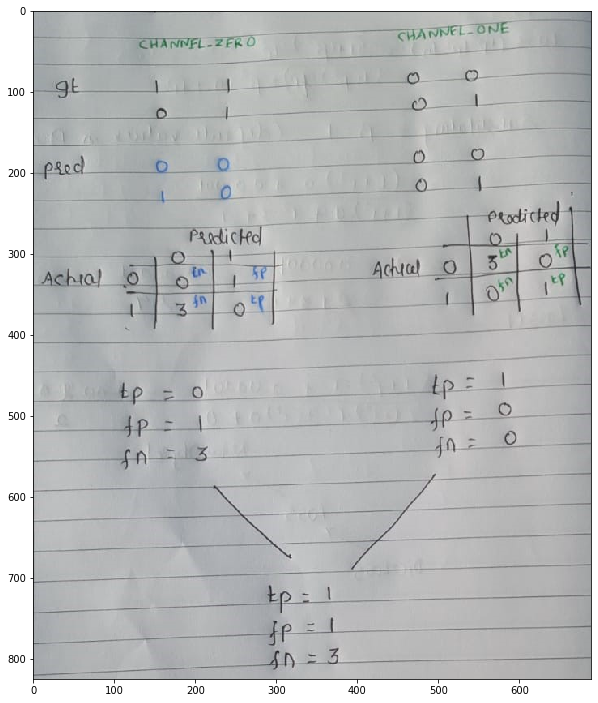

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

orig = cv2.imread('confusion_matrix.jpeg', cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(10, 15))
plt.imshow(orig)

In [21]:
# Code line:     score = ((1 + beta ** 2) * tp + smooth) \
#            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)

# Here the default value of smooth used by code is 1e-5 (or 0.00001). Alternatively, we can also pass this value while creating
# instance of DiceLoss. And default value of beta is 1. beta can also be passed while creating an instance of DiceLoss. 
# Just a reminder, above formula computes F1 Score. Let's go ahead and execute this line now.

beta = 1
smooth = 1e-5
score = ((1 + beta ** 2) * tp + smooth) \
        / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
score

<tf.Tensor: id=53, shape=(), dtype=float32, numpy=0.33333445>

In [22]:
# Now Diceloss is 1 - f1_score. Let's go ahead & calculate the same.

dl = 1 - score
dl

<tf.Tensor: id=55, shape=(), dtype=float32, numpy=0.66666555>

In [23]:
# So this value matches the DiceLoss calculated directly by using sm.losses.DiceLoss.

In [24]:
# Code line: score = average(score, per_image, class_weights, **kwargs)

# For simplicity, I just used one ground truth and corresponding predicted mask. In reality there would be a batch of 8 or 16 
# or 32 gt masks & corresponding predicted masks on which DiceLoss is calculated together. The average function 
# averages Diceloss of this entire batch.